# Experiment 3: Document at various level for datasets(COVID-science : non-science : Psychology)

## 1. Article level

In [1]:
#importing libraries
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as s
import dataframe_image as dfi
import networkx as nx
import mantel

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### LSA on covid-science.txt at article level

In [2]:
def load_data(path,file_name,seperator):
    """
    Input  : path and file_name
    function: loading text file
    Output : number of words, document list
    """
    
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r", encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            i=i+1
            if text !='':
                document = document+text
                if text == seperator:
                    documents_list.append(document)
                    document = ''
        documents_list.append(document)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [3]:
document_list,titles,word_count_science=load_data("","covid-science.txt",'NEW_PAPER')

Number of words in text file : 120257
Total Number of Documents: 20


In [4]:
#data preprocessing/cleaning
def preprocess_data(doc_set):
    """
    Input  : list of documents
    function: text preprocessing - word tokenize, removing english stopwords, and potter stemming 
    Output : clean text
    """
    # initialize regex tokenizer
    word_tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    eng_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    po_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = word_tokenizer.tokenize(raw)
        tokens = [i for i in tokens if len(i)>3]
        print(tokens)
        # removing english stop words from tokens
        stopped_tokens = [i for i in tokens if not i in eng_stop]
        # stemmed tokens
        stem_tokens = [po_stemmer.stem(i) for i in stopped_tokens]
        # list of tokens
        texts.append(stem_tokens)
    return texts

In [5]:
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnetmethodology', 'predicting', 'covid', '19based', 'chest', 'imagess', 'tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herreraabstract', 'currently', 'coronavirus', 'disease', 'covid', 'most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans', 'orchest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'mostmedical', 'centers', 'hence', 'many', 'cases', 'imagesbecome', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networkshave', 'great', 'potential', 'building', 'covid', 'triage', 'systemsand', 'detecting', 'covid', 'patients', 'especially', 'patients', 'withlow', 'severity', 'unfortunately', 'current', 'databases', 'allowbuilding', 'such', 'systems', 'they', 'highly', 'heterog

In [6]:
# preparing corpus for LSA
def prepare_corpus(doc_clean):
    """
    Input  : preprossed document
    function: creating term dictionary and document term matrix
    Output : term dictionary and Document Term Matrix
    """
    # every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    term_dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    docu_term_matrix = [term_dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return term_dictionary,docu_term_matrix

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : preprocessed document, number of topics and word count
    function: create LSA model using gensim
    Output : return LSA model
    """
    term_dictionary,docu_term_matrix=prepare_corpus(doc_clean)
    # LSA model
    lsamodel = LsiModel(docu_term_matrix, num_topics=number_of_topics, id2word = term_dictionary)  # train model
    return lsamodel

In [8]:
# LSA Model
number_of_topics=20
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_covid_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [9]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_articles = create_gensim_lsa_model(clean_text,number_of_topics,words)

In [10]:
#top 5 words from lsa
dict(model_science.show_topic(0, topn=5))

{'covid': 0.4819559123739421,
 'imag': 0.3305244842801084,
 'data': 0.25927028676543307,
 'use': 0.23373910286534985,
 'model': 0.2237104216675572}

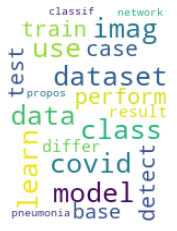

In [11]:
#wordcloud for top 10 words
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph12.png')

In [12]:
# cosinesimilarity matrix of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_covid_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_covid_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled15.png')

cosine-similarity
           covid       imag       data        use      model
covid          1    0.19987    0.36023   0.315797  0.0639177
imag     0.19987          1  -0.115461  0.0796236  -0.101251
data     0.36023  -0.115461          1 -0.0217574  0.0207809
use     0.315797  0.0796236 -0.0217574          1  0.0631737
model  0.0639177  -0.101251  0.0207809  0.0631737          1


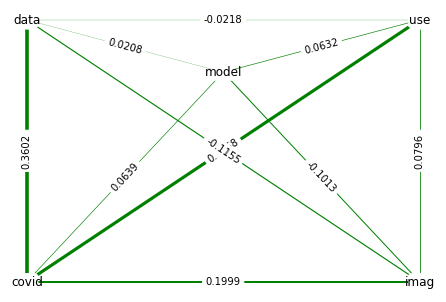

In [13]:
#networkx graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig15.png')

### LSA on covid-non-science.txt at article level

In [14]:
#loading document
document_list,titles,word_count_nscience=load_data("","covid-non-science.txt",'NEW NEWSPAPER')

Number of words in text file : 8713
Total Number of Documents: 20


In [15]:
#data preprocessing
clean_text=preprocess_data(document_list)

['covid', 'recovery', 'covid', 'realityby', 'reuterspublished', 'july', '2020', 'updated', 'july', '2020by', 'marc', 'joneslondon', 'july', 'reuters', 'world', 'shares', 'inched', 'towards', 'four', 'month', 'high', 'friday', 'industrial', 'bellwether', 'metal', 'copper', 'longest', 'weekly', 'winning', 'streak', 'nearly', 'three', 'years', 'recovering', 'global', 'data', 'kept', 'nagging', 'coronavirus', 'nerves', 'market', 'rally', 'fuelled', 'record', 'jobs', 'numbers', 'largely', 'blown', 'itself', 'amid', 'spike', 'covid', 'cases', 'though', 'fastest', 'expansion', 'china', 'services', 'sector', 'over', 'decade', 'more', 'stimulus', 'ensured', 'optimism', 'remained', 'chinese', 'shares', 'charged', 'their', 'highest', 'level', 'five', 'years', 'helping', 'asian', 'indexes', 'month', 'peaks', 'sight', 'european', 'markets', 'stalling', 'early', 'took', 'some', 'traders', 'surprise', 'currency', 'commodity', 'markets', 'also', 'subdued', 'feel', 'after', 'otherwise', 'strong', 'week

In [16]:
# LSA Model
number_of_topics=20
words=word_count_nscience
model_nscience=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_non_science =dict(model_nscience.show_topic(0, topn=words))#dict and encoding matrix values


In [17]:
#dictionary of top 5 words
dict(model_nscience.show_topic(0,topn=5))

{'test': 0.5425296037655409,
 'covid': 0.30373216046545803,
 'peopl': 0.2994432685604926,
 'symptom': 0.18363931537689843,
 'case': 0.18310800492471946}

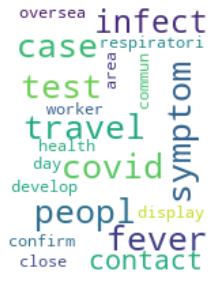

In [18]:
#wordcloud for top 10 words
from wordcloud import WordCloud
text = dict(model_nscience.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph7.png')

In [19]:
# cosine similarity matrix of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_covid_non_science =dict(model_nscience.show_topic(i, topn=words))
    b=pd.DataFrame(words_covid_non_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_nscience.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled7.png')

cosine-similarity
              test      covid      peopl    symptom       case
test             1  0.0622567   0.326012   0.864501    0.32399
covid    0.0622567          1   0.313763 -0.0833804   0.190355
peopl     0.326012   0.313763          1   0.446673 -0.0764638
symptom   0.864501 -0.0833804   0.446673          1   0.284991
case       0.32399   0.190355 -0.0764638   0.284991          1


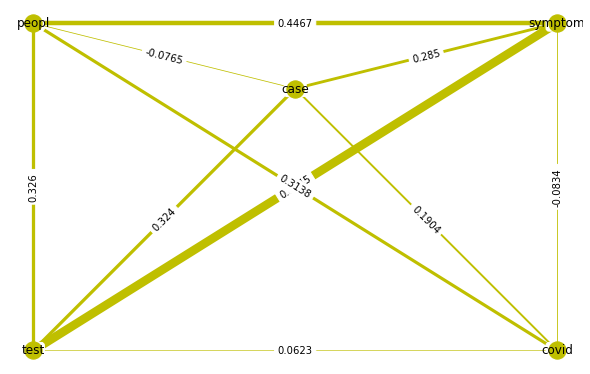

In [20]:
#networkx graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='y',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="y")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig7.png')

### lsa on covid-psychology.txt at article level

In [21]:
#data loading
document_list,titles,word_count_psy=load_data("","covid-psychology.txt",'NEW PAPER')

Number of words in text file : 86550
Total Number of Documents: 20


In [22]:
#data preprocessing
clean_text=preprocess_data(document_list)

['international', 'sociology2021', 'author', '2020article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissionsdoi', '1177', '0268580920948807journals', 'sagepub', 'home', 'isspsychology', 'politics', 'ofcovid', 'misinfodemics', 'peoplebelieve', 'misinfodemics', 'sonia', 'mukhtaruniversity', 'management', 'technology', 'lahore', 'pakistanabstractmisinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adversehealth', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicateevidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects', 'ofmisinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevierabout', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'reviewed', 'this', 'article', 'thisreview', 'examin

In [23]:
# LSA Model
number_of_topics=20
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))#dict and encoding matrix values


In [24]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_articles=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [25]:
#top 5 words from lsa
dict(model_psy.show_topic(0,topn=5))

{'2020': 0.42727157511952374,
 'covid': 0.32099481957500275,
 'psycholog': 0.22665575223350956,
 'social': 0.21129956668978256,
 'epidem': 0.16257116253243872}

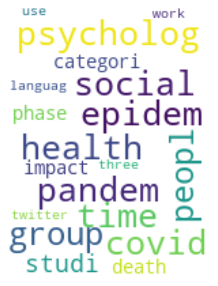

In [26]:
#wordcloud for top 10 words
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph27.png')

In [27]:
# cosine similarity matrix for top 5 words
a=pd.DataFrame()

for i in range(number_of_topics):
    words_psychology =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psychology,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled8.png')

cosine-similarity
                2020      covid psycholog     social     epidem
2020               1   0.282638  0.146216   0.086535  0.0550711
covid       0.282638          1  0.137066  0.0146927 -0.0702621
psycholog   0.146216   0.137066         1   0.116781   0.101001
social      0.086535  0.0146927  0.116781          1   0.434874
epidem     0.0550711 -0.0702621  0.101001   0.434874          1


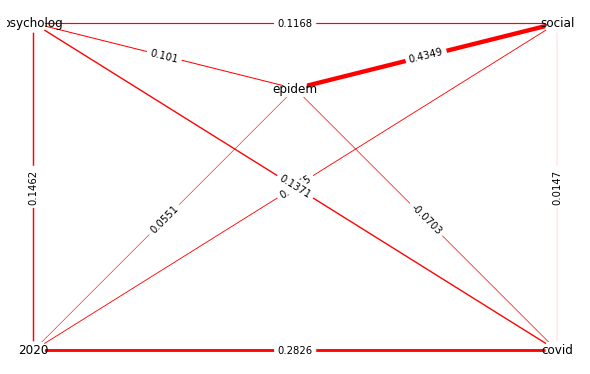

In [28]:
#networkx for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig8.png')

In [29]:
# defining mantel test function
def mantel_test(n):
    #all words from corpus
    words_science = dict(model_science.show_topic(0, topn=word_count_science))
    words_psy = dict(model_psy.show_topic(0, topn=word_count_psy))
    #top words from the corpus
    top_words_science = dict(model_science.show_topic(0, topn=n)) 
    top_words_psy = dict(model_psy.show_topic(0,topn=n)) 

    #Finding out the weights of top 5 law words in covid science and updating their weights w.r.t psychology dataset 
    c={} 
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)
    #Finding out the weights of top 5 law words in covid psychology and updating their weights w.r.t covid science dataset 
    b={} 
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for top 10 words in covid science
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_science.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace of top 10 words in psychology dataset
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_psy.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=100000, method='pearson', tail='upper')

In [30]:
mantel_test(5)

Pairwise-distance
               2020     covid    psycholog    social       epidem  \
2020              0  0.674002      0.36767  0.531836     0.396413   
covid      0.674002         0     0.629265  0.734645     0.650745   
psycholog   0.36767  0.629265  8.23181e-11  0.400991     0.102067   
social     0.531836  0.734645     0.400991         0     0.418365   
epidem     0.396413  0.650745     0.102067  0.418365  1.86265e-09   
imag       0.891661  0.906757     0.790683  0.916729     0.795824   
data       0.857554  0.768464     0.722907  0.832332     0.723699   
use        0.555855  0.657712     0.474182  0.666313     0.488571   
model      0.711022  0.902144      0.68823  0.806082     0.669871   

                  imag         data          use     model  
2020          0.891661     0.857554     0.555855  0.711022  
covid         0.906757     0.768464     0.657712  0.902144  
psycholog     0.790683     0.722907     0.474182   0.68823  
social        0.916729     0.832332     0.66631

(-0.533093121849338, 0.95076, -1.6363094990614924)

In [31]:
#mantel test with 20 word network

mantel_test(10)

Pairwise-distance
               2020     covid    psycholog    social       epidem    pandem  \
2020              0  0.674002      0.36767  0.531836     0.396413  0.418207   
covid      0.674002         0     0.629265  0.734645     0.650745  0.647843   
psycholog   0.36767  0.629265  8.23181e-11  0.400991     0.102067  0.172896   
social     0.531836  0.734645     0.400991         0     0.418365  0.368846   
epidem     0.396413  0.650745     0.102067  0.418365  1.86265e-09  0.132024   
pandem     0.418207  0.647843     0.172896  0.368846     0.132024         0   
health     0.371036  0.615536     0.172764  0.403539     0.189056  0.204128   
time       0.490966  0.687675     0.350242  0.493539     0.309363  0.378335   
group       0.37055  0.613001    0.0774391  0.394031     0.133837  0.188081   
peopl      0.348986  0.664598     0.258756   0.34618     0.284587  0.278945   
imag       0.891661  0.906757     0.790683  0.916729     0.795824  0.816846   
data       0.857554  0.768464     

(-0.513948348056973, 0.99636, -2.35975177848905)

In [32]:
# mantel test for covid science and non science dataset(Not necessary for experimental results of project)

def mantel_test_n(n):
    words_science = dict(model_science.show_topic(0, topn=word_count_science))
    words_nscience = dict(model_nscience.show_topic(0, topn=word_count_nscience))

    top_words_science = dict(model_science.show_topic(0, topn=n)) 
    top_words_nscience = dict(model_nscience.show_topic(0,topn=n)) 


    c={} #law words in non law
    for key in top_words_science:
        try:
            c[key] = words_nscience[key]
        except KeyError:
            c[key] = 0

    top_words_nscience.update(c)

    b={} 
    for key in top_words_nscience:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance 
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_science.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()
    #pairwise distace for non-law
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_nscience =dict(model_nscience.show_topic(i, topn=word_count_nscience))
        b=pd.DataFrame(words_from_nscience,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_nscience.keys()), 
                      index = list(top_words_nscience.keys()))

    l = list(top_words_nscience.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_nscience), k = 1)])

    return mantel.test(dist1, dist2, perms=100000, method='pearson', tail='upper')

In [33]:
mantel_test_n(5)

Pairwise-distance
                test     covid     peopl   symptom      case         imag  \
test     1.05367e-08  0.750979  0.491932  0.533855  0.798228     0.987696   
covid       0.750979         0  0.664598  0.621303  0.822785     0.906757   
peopl       0.491932  0.664598         0  0.270493  0.579838     0.854849   
symptom     0.533855  0.621303  0.270493         0  0.518144     0.792381   
case        0.798228  0.822785  0.579838  0.518144         0     0.940637   
imag        0.987696  0.906757  0.854849  0.792381  0.940637  1.49012e-08   
data        0.893981  0.768464  0.778094  0.726166  0.804397      1.13106   
use         0.665969  0.657712  0.532211  0.457572  0.667066     0.889194   
model       0.860115  0.902144  0.748253  0.692453  0.791349      1.09935   

                data          use     model  
test        0.893981     0.665969  0.860115  
covid       0.768464     0.657712  0.902144  
peopl       0.778094     0.532211  0.748253  
symptom     0.726166     0.

(-0.45038456855907627, 0.90518, -1.3821255209451901)

In [34]:
mantel_test_n(10)

Pairwise-distance
                    test     covid     peopl    symptom      case     travel  \
test         1.05367e-08  0.750979  0.491932   0.533855  0.798228   0.533196   
covid           0.750979         0  0.664598   0.621303  0.822785    0.62861   
peopl           0.491932  0.664598         0   0.270493  0.579838   0.259909   
symptom         0.533855  0.621303  0.270493          0  0.518144  0.0647461   
case            0.798228  0.822785  0.579838   0.518144         0   0.529687   
travel          0.533196   0.62861  0.259909  0.0647461  0.529687          0   
fever           0.528434  0.619159  0.266031  0.0488287  0.534801  0.0389511   
infect          0.642507  0.715799  0.495376   0.413898  0.581321   0.411621   
contact         0.493119  0.628239  0.235357  0.0944009  0.533702   0.100415   
respiratori      0.53334  0.624215  0.266039  0.0607611  0.519514  0.0466501   
imag            0.987696  0.906757  0.854849   0.792381  0.940637   0.792253   
data            0.8939

(-0.045145602008440484, 0.58879, -0.22155190658315219)

## 2. 2-3 paragraphs

### LSA on covid-science.txt at 2-3 paragraph level

In [35]:
#loading dataset
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    document = ''
    i=0
    with open( os.path.join(path, file_name) ,"r",encoding="utf8") as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for word in words:
                i=i+1
                document = document+word+' '
                if i == 200:
                    documents_list.append(document)
                    document,i = '',0
                    if len(documents_list) == 2:
                        break
    print("Total Number of Documents:",len(documents_list))
    #titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [36]:
document_list,titles,word_count_science=load_data("","covid-science.txt")

Number of words in text file : 120257
Total Number of Documents: 2


In [37]:
#data preprocessing
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet', 'methodology', 'predicting', 'covid', 'based', 'chest', 'images', 'tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte', 'guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova', 'olmedo', 'sánchez', 'herrera', 'abstract', 'currently', 'coronavirus', 'disease', 'covid', 'most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans', 'chest', 'images', 'computed', 'tomography', 'scanners', 'testing', 'available', 'most', 'medical', 'centers', 'hence', 'many', 'cases', 'images', 'become', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networks', 'have', 'great', 'potential', 'building', 'covid', 'triage', 'systems', 'detecting', 'covid', 'patients', 'especially', 'patients', 'with', 'severity', 'unfortunately', 'current', 'databases', 'allow', 'building', 'such', 'systems', 'they', 'high

In [38]:
# LSA Model
number_of_topics=2
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_science =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [39]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_p=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [40]:
#top 5 words from LSA
dict(model_science.show_topic(0, topn=5))

{'support': -0.30386095534296476,
 '2020': -0.23522191481735744,
 'granada': -0.23033778261060142,
 'covid': -0.21722636684891058,
 'programm': -0.2025739702286432}

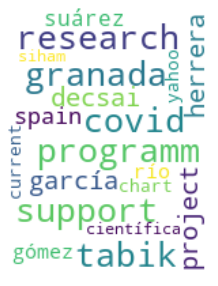

In [41]:
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph8.png')

In [42]:
# Cosine similarity matrix

a=pd.DataFrame()

for i in range(number_of_topics):
    words_covid_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_covid_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled9.png')

cosine-similarity
           support      2020   granada     covid  programm
support          1  0.524928  0.955931 -0.115612         1
2020      0.524928         1  0.751685  0.784751  0.524928
granada   0.955931  0.751685         1  0.181107  0.955931
covid    -0.115612  0.784751  0.181107         1 -0.115612
programm         1  0.524928  0.955931 -0.115612         1


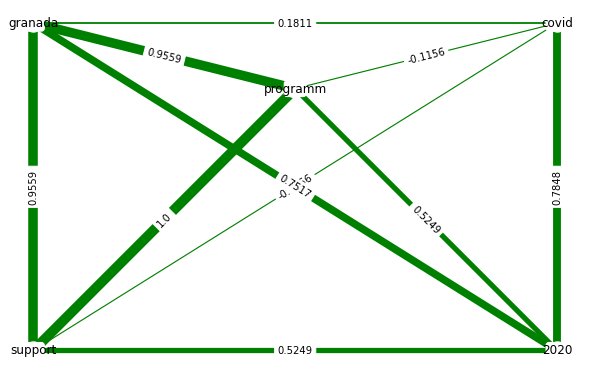

In [43]:
#networkx
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig9.png')

### LSA on covid-non-science.txt at 2-3 paragraph level

In [44]:
#data loading
document_list,titles,word_count_nscience=load_data("","covid-non-science.txt")

Number of words in text file : 8713
Total Number of Documents: 2


In [45]:
#data cleaning
clean_text=preprocess_data(document_list)

['covid', 'recovery', 'covid', 'reality', 'reuters', 'published', 'july', '2020', 'updated', 'july', '2020', 'marc', 'jones', 'london', 'july', 'reuters', 'world', 'shares', 'inched', 'towards', 'four', 'month', 'high', 'friday', 'industrial', 'bellwether', 'metal', 'copper', 'longest', 'weekly', 'winning', 'streak', 'nearly', 'three', 'years', 'recovering', 'global', 'data', 'kept', 'nagging', 'coronavirus', 'nerves', 'market', 'rally', 'fuelled', 'record', 'jobs', 'numbers', 'largely', 'blown', 'itself', 'amid', 'spike', 'covid', 'cases', 'though', 'fastest', 'expansion', 'china', 'services', 'sector', 'over', 'decade', 'more', 'stimulus', 'ensured', 'optimism', 'remained', 'chinese', 'shares', 'charged', 'their', 'highest', 'level', 'five', 'years', 'helping', 'asian', 'indexes', 'month', 'peaks', 'sight', 'european', 'markets', 'stalling', 'early', 'took', 'some', 'traders', 'surprise', 'currency', 'commodity', 'markets', 'also', 'subdued', 'feel', 'after', 'otherwise', 'strong', '

In [46]:
# LSA Model
number_of_topics=2
words=word_count_nscience
model_nscience=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_non_science =dict(model_nscience.show_topic(0, topn=words))##dict and encoding matrix values

In [47]:
#top 5 words
dict(model_nscience.show_topic(0, topn=5))

{'market': 0.264353040306379,
 'rate': 0.18754847840846847,
 'juli': 0.1791266417580859,
 'covid': 0.17912664175808563,
 'june': 0.17045279709658656}

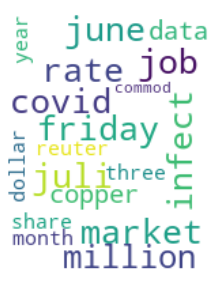

In [48]:
#wordcloud of top 10 words
from wordcloud import WordCloud
text = dict(model_nscience.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph9.png')

In [49]:
# cosine similarity matrix for top 5 words
a=pd.DataFrame()

for i in range(number_of_topics):
    words_covid_non_science =dict(model_nscience.show_topic(i, topn=words))
    b=pd.DataFrame(words_covid_non_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_nscience.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled10.png')

cosine-similarity
          market      rate      juli     covid      june
market         1  0.711061  0.771166  0.771166  0.459512
rate    0.711061         1   0.10071   0.10071  0.951241
juli    0.771166   0.10071         1         1  -0.21108
covid   0.771166   0.10071         1         1  -0.21108
june    0.459512  0.951241  -0.21108  -0.21108         1


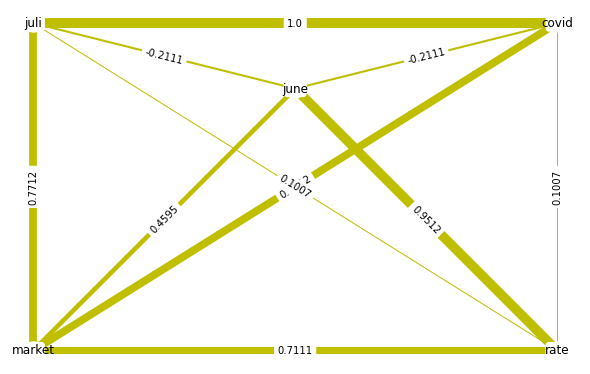

In [50]:
#networkx
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='y',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig10.png')

### LSA on covid-psychology.txt at 2-3 paragraph level

In [51]:
#data losding
document_list,titles,word_count_psy=load_data("","covid-psychology.txt")

Number of words in text file : 86550
Total Number of Documents: 2


In [52]:
#data preprocessing
clean_text=preprocess_data(document_list)

['international', 'sociology', '2021', 'author', '2020', 'article', 'reuse', 'guidelines', 'sagepub', 'journals', 'permissions', '1177', '0268580920948807', 'journals', 'sagepub', 'home', 'psychology', 'politics', 'covid', 'misinfodemics', 'people', 'believe', 'misinfodemics', 'sonia', 'mukhtar', 'university', 'management', 'technology', 'lahore', 'pakistan', 'abstract', 'misinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adverse', 'health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate', 'evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects', 'misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier', 'about', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'reviewed', 'this', 'a

In [53]:
# LSA Model
number_of_topics=2
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [54]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_p = create_gensim_lsa_model(clean_text,number_of_topics,words)

In [55]:
#dictionary of top 5 words
dict(model_psy.show_topic(0, topn=5))

{'misinfodem': 0.4936266655941646,
 'covid': 0.3571916107745935,
 'articl': 0.21002057347124545,
 'mechan': 0.14717103730334843,
 'health': 0.1471710373033483}

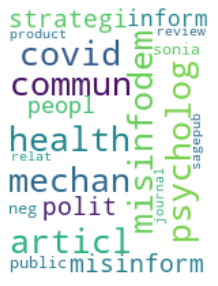

In [56]:
#wordcloud
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph28.png')

In [57]:
# Cosinesimilarity matrix for top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psychology =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psychology,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled11.png')

cosine-similarity
           misinfodem     covid    articl    mechan    health
misinfodem          1  0.977431  0.994116  0.761706  0.761706
covid        0.977431         1  0.948797  0.881393  0.881393
articl       0.994116  0.948797         1  0.687043  0.687043
mechan       0.761706  0.881393  0.687043         1         1
health       0.761706  0.881393  0.687043         1         1


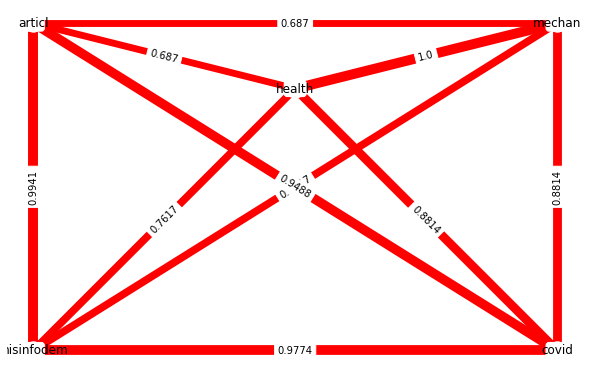

In [58]:
#networkx graph for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig11.png')

In [59]:
#mantel test for 10 word network
mantel_test(5)

Pairwise-distance
           misinfodem     covid    articl mechan health   support      2020  \
misinfodem          0         0         0      0      0         0         0   
covid               0         0  0.360337      0      0  0.608033  0.282616   
articl              0  0.360337         0      0      0  0.404283  0.208896   
mechan              0         0         0      0      0         0         0   
health              0         0         0      0      0         0         0   
support             0  0.608033  0.404283      0      0         0  0.327071   
2020                0  0.282616  0.208896      0      0  0.327071         0   
granada             0  0.457677  0.252649      0      0  0.161988  0.175514   
programm            0  0.526543  0.280864      0      0  0.126325  0.246469   

              granada   programm  
misinfodem          0          0  
covid        0.457677   0.526543  
articl       0.252649   0.280864  
mechan              0          0  
health          

(-0.27891572318575647, 0.87877, -1.1456133484409994)

In [60]:
#mantel test for 20 word network
mantel_test(10)

Pairwise-distance
           misinfodem     covid    articl mechan health commun psycholog  \
misinfodem          0         0         0      0      0      0         0   
covid               0         0  0.360337      0      0      0         0   
articl              0  0.360337         0      0      0      0         0   
mechan              0         0         0      0      0      0         0   
health              0         0         0      0      0      0         0   
commun              0         0         0      0      0      0         0   
psycholog           0         0         0      0      0      0         0   
strategi            0         0         0      0      0      0         0   
misinform           0         0         0      0      0      0         0   
polit               0         0         0      0      0      0         0   
support             0  0.608033  0.404283      0      0      0         0   
2020                0  0.282616  0.208896      0      0      0        

(-0.16544931052577933, 0.8724, -1.1200916601203454)

In [61]:
mantel_test_n(5)

Pairwise-distance
         market rate juli     covid june   support      2020    granada  \
market        0    0    0         0    0         0         0          0   
rate          0    0    0         0    0         0         0          0   
juli          0    0    0         0    0         0         0          0   
covid         0    0    0         0    0  0.608033  0.282616   0.457677   
june          0    0    0         0    0         0         0          0   
support       0    0    0  0.608033    0         0  0.327071   0.161988   
2020          0    0    0  0.282616    0  0.327071         0   0.175514   
granada       0    0    0  0.457677    0  0.161988  0.175514          0   
programm      0    0    0  0.526543    0  0.126325  0.246469  0.0742376   

           programm  
market            0  
rate              0  
juli              0  
covid      0.526543  
june              0  
support    0.126325  
2020       0.246469  
granada   0.0742376  
programm          0  
Pairwise-di

(-0.3211636322477467, 0.97417, -1.4414045746819804)

In [62]:
mantel_test_n(10)

Pairwise-distance
         market rate juli     covid june also friday job infect million  \
market        0    0    0         0    0    0      0   0      0       0   
rate          0    0    0         0    0    0      0   0      0       0   
juli          0    0    0         0    0    0      0   0      0       0   
covid         0    0    0         0    0    0      0   0      0       0   
june          0    0    0         0    0    0      0   0      0       0   
also          0    0    0         0    0    0      0   0      0       0   
friday        0    0    0         0    0    0      0   0      0       0   
job           0    0    0         0    0    0      0   0      0       0   
infect        0    0    0         0    0    0      0   0      0       0   
million       0    0    0         0    0    0      0   0      0       0   
support       0    0    0  0.608033    0    0      0   0      0       0   
2020          0    0    0  0.282616    0    0      0   0      0       0   
granada

(-0.24513328801204826, 0.99907, -1.8270394036391986)

## 3. Paragraph level

### LSA on covid-science.txt at paragraph level

In [63]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r",encoding='UTF8') as fin:
        data = fin.read()
        words = data.split()
        fin.seek(0)
        print('Number of words in text file :', len(words))
        for line in fin.readlines():
            text = line.strip()
            if text !='':
                documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles,len(words)

In [64]:
document_list,titles,word_count_science=load_data("","covid-science.txt")

Number of words in text file : 120257
Total Number of Documents: 14379


In [65]:
#data cleaning
clean_text=preprocess_data(document_list)

['covidgr', 'dataset', 'covid', 'sdnet']
['methodology', 'predicting', 'covid']
['based', 'chest', 'images']
['tabik', 'gómez', 'ríos', 'martín', 'rodríguez', 'sevillano', 'garcía', 'area', 'charte']
['guirado', 'suárez', 'luengo', 'valero', 'gonzález', 'garcía', 'villanova']
['olmedo', 'sánchez', 'herrera']
['abstract', 'currently', 'coronavirus', 'disease', 'covid']
['most', 'infectious', 'diseases', '21st', 'century', 'diagnosed', 'using', 'testing', 'scans']
['chest', 'images', 'computed', 'tomography']
['scanners', 'testing', 'available', 'most']
['medical', 'centers', 'hence', 'many', 'cases', 'images']
['become', 'most', 'time', 'cost', 'effective', 'tool', 'assisting', 'clinicians', 'making', 'decisions', 'deep', 'learning', 'neural', 'networks']
['have', 'great', 'potential', 'building', 'covid', 'triage', 'systems']
['detecting', 'covid', 'patients', 'especially', 'patients', 'with']
['severity', 'unfortunately', 'current', 'databases', 'allow']
['building', 'such', 'systems'

In [66]:
# LSA Model
number_of_topics=100
words=word_count_science
model_science=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_law =dict(model_science.show_topic(0, topn=words))##dict and encoding matrix values

In [67]:
#These variables are for further experimentation in vertical comparission mantel test
model_science_paragraph=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [68]:
#top 5 words from lsa
dict(model_science.show_topic(0, topn=5))

{'covid': 0.7824307537118228,
 'imag': 0.3483697703449934,
 'use': 0.19262982910237736,
 'data': 0.16979352187609095,
 'model': 0.1434213806427849}

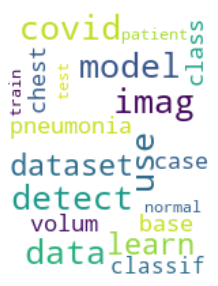

In [69]:
#word cloud of top 10 words
from wordcloud import WordCloud
text = dict(model_science.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph10.png')

In [70]:
# cosine similarity of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_science =dict(model_science.show_topic(i, topn=words))
    b=pd.DataFrame(words_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_science.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled12.png')

cosine-similarity
             covid         imag          use         data        model
covid            1   0.00105585 -5.09149e-05   0.00048856  0.000807228
imag    0.00105585            1 -0.000564989  -0.00559808    0.0011847
use   -5.09149e-05 -0.000564989            1   8.0517e-05   0.00060903
data    0.00048856  -0.00559808   8.0517e-05            1 -0.000274743
model  0.000807228    0.0011847   0.00060903 -0.000274743            1


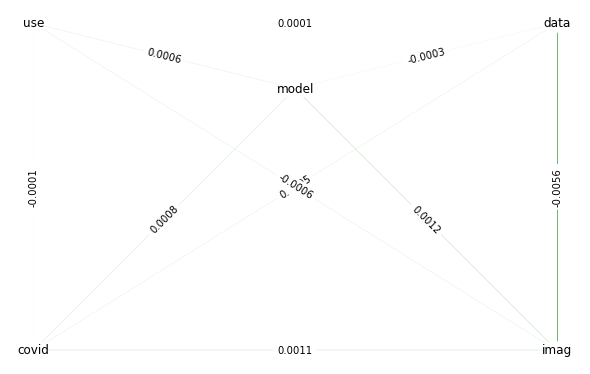

In [71]:
#networkx of top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *100  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='g',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig12.png')

### LSA on covid-non-science-small.txt at 2-3 paragraph level

In [72]:
#data loading
document_list,titles,word_count_nscience=load_data("","covid-non-science.txt")

Number of words in text file : 8713
Total Number of Documents: 387


In [73]:
#data preprocessing
clean_text=preprocess_data(document_list)

['covid', 'recovery', 'covid', 'reality']
['reuters']
['published', 'july', '2020', 'updated', 'july', '2020']
['marc', 'jones']
['london', 'july', 'reuters', 'world', 'shares', 'inched', 'towards', 'four', 'month', 'high', 'friday', 'industrial', 'bellwether', 'metal', 'copper', 'longest', 'weekly', 'winning', 'streak', 'nearly', 'three', 'years', 'recovering', 'global', 'data', 'kept', 'nagging', 'coronavirus', 'nerves']
['market', 'rally', 'fuelled', 'record', 'jobs', 'numbers', 'largely', 'blown', 'itself', 'amid', 'spike', 'covid', 'cases', 'though', 'fastest', 'expansion', 'china', 'services', 'sector', 'over', 'decade', 'more', 'stimulus', 'ensured', 'optimism', 'remained']
['chinese', 'shares', 'charged', 'their', 'highest', 'level', 'five', 'years', 'helping', 'asian', 'indexes', 'month', 'peaks', 'sight', 'european', 'markets', 'stalling', 'early', 'took', 'some', 'traders', 'surprise']
['currency', 'commodity', 'markets', 'also', 'subdued', 'feel', 'after', 'otherwise', 'str

In [74]:
# LSA Model
number_of_topics=100
words=word_count_nscience
model_nscience=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_non_science =dict(model_nscience.show_topic(0, topn=words))##dict and encoding matrix values

In [75]:
#top 5 words from lsa
dict(model_nscience.show_topic(0, topn=5))

{'trial': -0.42977519738264497,
 'vaccin': -0.3531586004468163,
 'stage': -0.3053952578874054,
 'late': -0.2756054075105182,
 'expect': -0.21725840938344546}

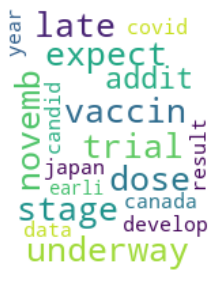

In [76]:
#word cloud for top 5 words
from wordcloud import WordCloud
text = dict(model_nscience.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph11.png')

In [77]:
# cosine similarity of top 5 words


a=pd.DataFrame()

for i in range(number_of_topics):
    words_non_science =dict(model_nscience.show_topic(i, topn=words))
    b=pd.DataFrame(words_non_science,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_nscience.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled13.png')

cosine-similarity
            trial     vaccin     stage       late    expect
trial           1  0.0812451  0.884778   0.710032  0.642674
vaccin  0.0812451          1  0.127836  0.0928863  0.029285
stage    0.884778   0.127836         1   0.782065  0.659594
late     0.710032  0.0928863  0.782065          1  0.553493
expect   0.642674   0.029285  0.659594   0.553493         1


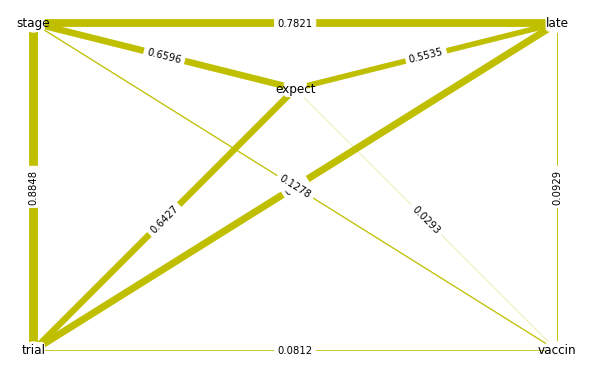

In [78]:
#networkx for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *10  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='y',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig13.png')

### LSA on covid-psychology-small.txt at paragraph level

In [79]:
# data loading
document_list,titles,word_count_psy=load_data("","covid-psychology.txt")

Number of words in text file : 86550
Total Number of Documents: 9007


In [80]:
#data cleaning
clean_text=preprocess_data(document_list)

['international', 'sociology']
['2021']
['author', '2020']
['article', 'reuse', 'guidelines']
['sagepub', 'journals', 'permissions']
['1177', '0268580920948807']
['journals', 'sagepub', 'home']
['psychology', 'politics']
['covid', 'misinfodemics']
['people']
['believe', 'misinfodemics']
['sonia', 'mukhtar']
['university', 'management', 'technology', 'lahore', 'pakistan']
['abstract']
['misinfodemics', 'related', 'covid', 'have', 'negatively', 'impacted', 'people', 'lives', 'with', 'adverse']
['health', 'psycho', 'sociopolitical', 'outcomes', 'scientific', 'community', 'seeks', 'communicate']
['evidence', 'based', 'information', 'regarding', 'misplaced', 'preventive', 'strategies', 'misinformed', 'helpseeking', 'behaviors', 'global', 'multifaceted', 'systems', 'secondary', 'risk', 'emerged', 'effects']
['misinfodemics', 'public', 'published', 'articles', 'pubmed', 'embase', 'google', 'scholar', 'elsevier']
['about', 'covid', 'related', 'misinfodemics', 'have', 'been', 'considered', 'rev

In [81]:
# LSA Model
number_of_topics=100
words=word_count_psy
model_psy=create_gensim_lsa_model(clean_text,number_of_topics,words)
words_from_psychology =dict(model_psy.show_topic(0, topn=words))##dict and encoding matrix values

In [82]:
#These variables are for further experimentation in vertical comparission mantel test
model_psy_paragraph=create_gensim_lsa_model(clean_text,number_of_topics,words)

In [83]:
#top 5 words from lsa
dict(model_psy.show_topic(0, topn=5))

{'2020': 0.744760590312811,
 'covid': 0.2746753833089446,
 'pandem': 0.22338134342717259,
 'health': 0.20627927347916214,
 'polici': 0.15875976238455333}

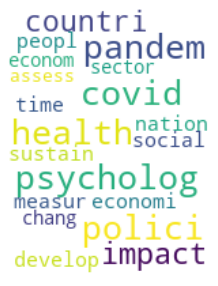

In [84]:
#word cloud for top 10 words
from wordcloud import WordCloud
text = dict(model_psy.show_topic(0, topn=20))
l=list(text.keys())
wordcloud = WordCloud(width=150, height=200,max_font_size=25, max_words=20, background_color="white").generate(" ".join(l))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('graph29.png')

In [85]:
# cosine similarity of top 5 words

a=pd.DataFrame()

for i in range(number_of_topics):
    words_psychology =dict(model_psy.show_topic(i, topn=words))
    b=pd.DataFrame(words_psychology,index=[i])
    a=a.append(b)

a=a.transpose()

top_words = dict(model_psy.show_topic(0,topn=5))

df = pd.DataFrame(columns=list(top_words.keys()), 
                  index = list(top_words.keys()))

l = list(top_words.keys())
print('cosine-similarity')
for i in l:
    for j in l:
            matrix=np.array([a.loc[i],a.loc[j]])
            n = s.metrics.pairwise.cosine_similarity(matrix, matrix, dense_output=True)
            df.loc[[i],[j]] = n[0,1]
print(df)

dfi.export(df, 'df_styled14.png')

cosine-similarity
               2020        covid       pandem       health      polici
2020              1 -5.71895e-05  0.000716471  0.000112255 -0.00409684
covid  -5.71895e-05            1   0.00019057  -0.00189745  0.00221843
pandem  0.000716471   0.00019057            1  -0.00179825  -0.0134542
health  0.000112255  -0.00189745  -0.00179825            1 -0.00486343
polici  -0.00409684   0.00221843   -0.0134542  -0.00486343           1


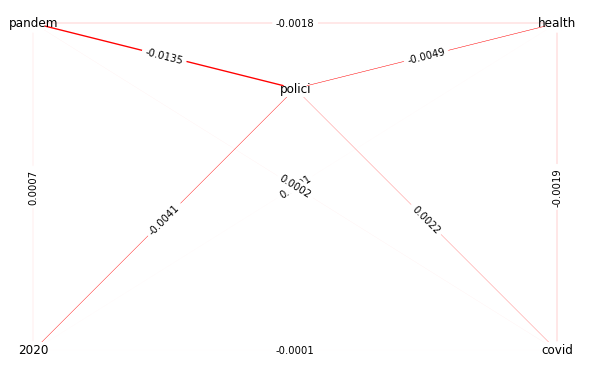

In [86]:
#networkx for top 5 words
df = df.apply(pd.to_numeric, errors='coerce')

df=df.round(4)

l = list(top_words.keys())

df_adj = pd.DataFrame(df.to_numpy(), index=l, columns=l)
G = nx.from_pandas_adjacency(df)
pos = {l[0]: (0, 0),l[1]: (1, 0), l[2]: (0, 1), l[3]: (1, 1), l[4]: (0.5, 0.8)}
a=list(G.edges(data=True))

b=[]
for i in a:
    b.append(i[:][2]['weight'])
w = [x *100  for x in b]

colors = range(4)
nx.draw(G,pos, alpha=1, width=w, with_labels = True,node_size=200, edge_color='r',node_color='b')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_nodes(G, pos, nodelist=l, node_color="w")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.rcParams["figure.figsize"] = (8,5)
plt.savefig('fig14.png')

In [87]:
mantel_test(5)

Pairwise-distance
            2020        covid    pandem       health    polici      imag  \
2020           0      1.37262   1.03537      1.28802  0.951978   1.36784   
covid    1.37262  1.49012e-08   1.07174      1.32865  0.995743   1.40464   
pandem   1.03537      1.07174         0     0.950417  0.452413   1.09894   
health   1.28802      1.32865  0.950417  2.10734e-08  0.879383    1.3261   
polici  0.951978     0.995743  0.452413     0.879383         0  0.997534   
imag     1.36784      1.40464   1.09894       1.3261  0.997534         0   
use      1.37058      1.40725   1.09596      1.32584    0.9984   1.40638   
data     1.36572      1.40266   1.08629      1.32313  0.987681   1.40569   
model    1.37009      1.40533   1.09521      1.32659  0.998399   1.40384   

            use      data     model  
2020    1.37058   1.36572   1.37009  
covid   1.40725   1.40266   1.40533  
pandem  1.09596   1.08629   1.09521  
health  1.32584   1.32313   1.32659  
polici   0.9984  0.987681  0.99

(0.08137012686728233, 0.3607, 0.23074039777307215)

In [88]:
mantel_test(10)

Pairwise-distance
               2020        covid    pandem       health     polici  psycholog  \
2020              0      1.37262   1.03537      1.28802   0.951978    0.94286   
covid       1.37262  1.49012e-08   1.07174      1.32865   0.995743   0.994685   
pandem      1.03537      1.07174         0     0.950417   0.452413   0.459164   
health      1.28802      1.32865  0.950417  2.10734e-08   0.879383   0.876935   
polici     0.951978     0.995743  0.452413     0.879383          0  0.0870882   
psycholog   0.94286     0.994685  0.459164     0.876935  0.0870882          0   
impact     0.948046     0.994606  0.462294     0.841503   0.116237  0.0916567   
countri    0.998861      1.06166  0.495437     0.914789   0.373444   0.359153   
develop     1.07845      1.12368  0.672038      1.05522   0.500555   0.514655   
nation     0.974168      1.02459  0.508374     0.847533   0.256235   0.229322   
imag        1.36784      1.40464   1.09894       1.3261   0.997534   0.992911   
use       

(-0.2274986076411022, 0.83863, -1.0285543569883562)

In [89]:
mantel_test_n(5)

Pairwise-distance
              trial    vaccin      stage       late     expect        covid  \
trial   3.29272e-10  0.334496  0.0652737  0.0457902  0.0703069     0.994227   
vaccin     0.334496         0   0.334689   0.337998   0.340189      1.04304   
stage     0.0652737  0.334689          0  0.0777504  0.0996353     0.994919   
late      0.0457902  0.337998  0.0777504          0  0.0815712     0.995989   
expect    0.0703069  0.340189  0.0996353  0.0815712          0     0.997507   
covid      0.994227   1.04304   0.994919   0.995989   0.997507  1.49012e-08   
imag       0.993552   1.04936    0.99207   0.992168   0.997729      1.40464   
use        0.995028   1.05179   0.996482   0.996607    1.00076      1.40725   
data       0.990223   1.04285   0.990314   0.990646   0.990675      1.40266   
model      0.994301   1.04815   0.993383   0.993458   0.992835      1.40533   

            imag       use      data     model  
trial   0.993552  0.995028  0.990223  0.994301  
vaccin   1.049

(0.01692738224462807, 0.49391, 0.057919303838280166)

In [90]:
mantel_test_n(10)

Pairwise-distance
                 trial    vaccin      stage       late     expect dose  \
trial      3.29272e-10  0.334496  0.0652737  0.0457902  0.0703069    0   
vaccin        0.334496         0   0.334689   0.337998   0.340189    0   
stage        0.0652737  0.334689          0  0.0777504  0.0996353    0   
late         0.0457902  0.337998  0.0777504          0  0.0815712    0   
expect       0.0703069  0.340189  0.0996353  0.0815712          0    0   
dose                 0         0          0          0          0    0   
underway             0         0          0          0          0    0   
novemb       0.0455113  0.329619  0.0726449  0.0536986  0.0863373    0   
addit         0.148744   0.34895   0.159562   0.144459    0.15068    0   
develop       0.513383   0.43076   0.528358   0.506117   0.512406    0   
covid         0.994227   1.04304   0.994919   0.995989   0.997507    0   
imag          0.993552   1.04936    0.99207   0.992168   0.997729    0   
use           0.9950

(-0.07008842952957238, 0.62502, -0.34371128200507034)

## Vertical mantel test
### Considering two spaces in matel tests as
### Article level -----> 2-3 Paragraph level , 
### Article---->Paragraph level,
### Paragraph----> 2-3 Paragraph level

In [91]:
def mantel_test_verticle(model_a,model_b,n):
    #all words from the cleaned documents
    words_science = dict(model_a.show_topic(0, topn=word_count_science))
    words_psy = dict(model_b.show_topic(0, topn=word_count_psy))
    #top 5 words from the documents
    top_words_science = dict(model_a.show_topic(0, topn=n)) 
    top_words_psy = dict(model_b.show_topic(0,topn=n)) 
    
    #Finding out the weights of top 5 law words in  model_a level and updating their weights w.r.t model b dataset 
    c={} 
    for key in top_words_science:
        try:
            c[key] = words_psy[key]
        except KeyError:
            c[key] = 0

    top_words_psy.update(c)
    #Finding out the weights of top 5 law words in model b and updating their weights w.r.t model a dataset
    b={} 
    for key in top_words_psy:
        try:
            b[key] = words_science[key]
        except KeyError:
            b[key] = 0

    b.update(top_words_science)
    top_words_science=b

    #pairwise distance for top 10 words in model a
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_science =dict(model_a.show_topic(i, topn=word_count_science))
        b=pd.DataFrame(words_from_science,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_science.keys()), 
                      index = list(top_words_science.keys()))

    l = list(top_words_science.keys())

    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df1 = df.to_numpy()

    #pairwise distance for top 10 words in model b
    a=pd.DataFrame()

    for i in range(number_of_topics):
        words_from_psy =dict(model_b.show_topic(i, topn=word_count_psy))
        b=pd.DataFrame(words_from_psy,index=[i])
        a=a.append(b)

    a=a.transpose()

    df = pd.DataFrame(columns=list(top_words_psy.keys()), 
                      index = list(top_words_psy.keys()))

    l = list(top_words_psy.keys())
    print('Pairwise-distance')
    for i in l:
        for j in l:
            try:
                matrix=np.array([a.loc[i],a.loc[j]])
            except KeyError:
                matrix=np.zeros((2,3))
            n = s.metrics.pairwise.nan_euclidean_distances(matrix, matrix)
            df.loc[[i],[j]] = n[0,1]
    print(df)
    df2 = df.to_numpy()
    

    dist1 = list(df1[np.triu_indices(len(top_words_science), k = 1)])

    

    dist2 = list(df2[np.triu_indices(len(top_words_psy), k = 1)])

    return mantel.test(dist1, dist2, perms=10000, method='pearson', tail='upper')

In [92]:
mantel_test_verticle(model_science_articles,model_science_p,5)

Pairwise-distance
           support      2020    granada    covid   programm     imag  \
support          0  0.816641   0.188647  1.34497   0.187055  1.80116   
2020      0.816641         0   0.837019  1.50711   0.825008  1.99382   
granada   0.188647  0.837019          0  1.38721  0.0724919  1.77803   
covid      1.34497   1.50711    1.38721        0     1.3995  2.02757   
programm  0.187055  0.825008  0.0724919   1.3995          0  1.77059   
imag       1.80116   1.99382    1.77803  2.02757    1.77059        0   
data       1.54057   1.91755    1.62324  1.71834    1.61751  2.52912   
use       0.993312   1.24293    1.08391  1.47069    1.06767   1.9883   
model      1.58459   1.58989    1.53724  2.01725    1.53708  2.45821   

                 data        use    model  
support       1.54057   0.993312  1.58459  
2020          1.91755    1.24293  1.58989  
granada       1.62324    1.08391  1.53724  
covid         1.71834    1.47069  2.01725  
programm      1.61751    1.06767  1.53708

(0.07343425434503273, 0.3845, 0.3350390539943082)

In [93]:
mantel_test_verticle(model_science_articles,model_science_paragraph,5)

Pairwise-distance
         covid     imag        use         data    model
covid        0  2.02757    1.47069      1.71834  2.01725
imag   2.02757        0     1.9883      2.52912  2.45821
use    1.47069   1.9883  1.666e-08      1.95244  1.81286
data   1.71834  2.52912    1.95244  4.71216e-08  2.20772
model  2.01725  2.45821    1.81286      2.20772        0
Pairwise-distance
         covid     imag      use     data        model
covid        0  1.40421  1.40727  1.40273      1.40531
imag   1.40421        0  1.40628  1.40572       1.4035
use    1.40727  1.40628        0  1.40388      1.40595
data   1.40273  1.40572  1.40388        0      1.40268
model  1.40531   1.4035  1.40595  1.40268  2.10734e-08


(-0.32039903892431343, 0.7666666666666667, -0.8612915497586047)

In [94]:
mantel_test_verticle(model_science_p,model_science_paragraph,5)

Pairwise-distance
            covid     imag      use         data    model   support     2020  \
covid           0  1.52372  2.54797       3.2917  2.54797   4.29945   1.9984   
imag      1.52372        0  1.04988       1.9984  1.04988   3.43628  1.33987   
use       2.54797  1.04988        0      1.14543        0   2.85871  1.47712   
data       3.2917   1.9984  1.14543  1.86265e-08  1.14543    1.7865  1.52372   
model     2.54797  1.04988        0      1.14543        0   2.85871  1.47712   
support   4.29945  3.43628  2.85871       1.7865  2.85871         0  2.31274   
2020       1.9984  1.33987  1.47712      1.52372  1.47712   2.31274        0   
granada   3.23626  2.29085   1.7865     0.913734   1.7865   1.14543  1.24107   
programm  3.72322  2.66513  1.98601     0.893249  1.98601  0.893249   1.7428   

           granada     programm  
covid      3.23626      3.72322  
imag       2.29085      2.66513  
use         1.7865      1.98601  
data      0.913734     0.893249  
model      

(0.10610382106187127, 0.3988, 0.4236923509288503)

In [95]:
mantel_test_verticle(model_psy_articles,model_psy_p,5)

Pairwise-distance
           misinfodem    covid       articl       commun      mechan     2020  \
misinfodem   8.33e-09  1.34189     0.738596      0.47164    0.410331  1.55979   
covid         1.34189        0      1.23555       1.3068     1.27012  1.64398   
articl       0.738596  1.23555  1.17804e-08     0.689709    0.459477  1.31627   
commun        0.47164   1.3068     0.689709  1.17804e-08    0.371932   1.4797   
mechan       0.410331  1.27012     0.459477     0.371932  2.9451e-09   1.4595   
2020          1.55979  1.64398      1.31627       1.4797      1.4595        0   
psycholog     1.33778   1.5689        1.104      1.07665     1.13502   1.6757   
social        1.03298  1.63894      1.17862      1.03988     1.00005   1.6997   
epidem        1.16331  1.65599      1.11923      1.11811    0.981829  1.68517   

            psycholog   social     epidem  
misinfodem    1.33778  1.03298    1.16331  
covid          1.5689  1.63894    1.65599  
articl          1.104  1.17862    1.119

(-0.06374745393273847, 0.5867, -0.2263477316643351)

In [96]:
mantel_test_verticle(model_psy_articles,model_psy_paragraph,5)

Pairwise-distance
              2020    covid    pandem   health    polici  psycholog   social  \
2020             0  1.64398   1.21093  1.63587   1.38208     1.6757   1.6997   
covid      1.64398        0   1.24569  1.92675   1.26996     1.5689  1.63894   
pandem     1.21093  1.24569         0  1.41086  0.788078    1.17936  1.32541   
health     1.63587  1.92675   1.41086        0   1.46491    1.41224  1.67666   
polici     1.38208  1.26996  0.788078  1.46491  8.33e-09     1.0708  1.13705   
psycholog   1.6757   1.5689   1.17936  1.41224    1.0708  1.666e-08  1.40467   
social      1.6997  1.63894   1.32541  1.67666   1.13705    1.40467        0   
epidem     1.68517  1.65599   1.34219  1.68828   1.03278    1.36759  1.05316   

              epidem  
2020         1.68517  
covid        1.65599  
pandem       1.34219  
health       1.68828  
polici       1.03278  
psycholog    1.36759  
social       1.05316  
epidem     3.332e-08  
Pairwise-distance
                  2020    covid     

(0.5650443081417844, 0.0453, 1.6640248141204788)

In [97]:
mantel_test_verticle(model_psy_p,model_psy_paragraph,5)

Pairwise-distance
                2020    covid   pandem       health polici misinfodem  \
2020               0  2.07845  1.31385     0.554403      0    3.31627   
covid        2.07845        0  2.67852      1.65813      0    1.33926   
pandem       1.31385  2.67852        0      1.20521      0    4.01777   
health      0.554403  1.65813  1.20521            0      0    2.96288   
polici             0        0        0            0      0          0   
misinfodem   3.31627  1.33926  4.01777      2.96288      0          0   
articl       1.33926  1.10881  2.41043      1.20521      0    2.07845   
commun      0.554403  1.65813  1.20521            0      0    2.96288   
mechan      0.554403  1.65813  1.20521  1.31709e-08      0    2.96288   

             articl    commun       mechan  
2020        1.33926  0.554403     0.554403  
covid       1.10881   1.65813      1.65813  
pandem      2.41043   1.20521      1.20521  
health      1.20521         0  1.31709e-08  
polici            0       

(-0.11802488631885512, 0.6568, -0.4046262850059532)

In [98]:
mantel_test_verticle(model_science_articles,model_science_p,10)

Pairwise-distance
           support      2020    granada    covid  research   programm  \
support          0  0.816641   0.188647  1.34497  0.327252   0.187055   
2020      0.816641         0   0.837019  1.50711  0.857407   0.825008   
granada   0.188647  0.837019          0  1.38721  0.268729  0.0724919   
covid      1.34497   1.50711    1.38721        0   1.32888     1.3995   
research  0.327252  0.857407   0.268729  1.32888         0   0.247326   
programm  0.187055  0.825008  0.0724919   1.3995  0.247326          0   
tabik     0.207205  0.849983  0.0543689  1.38042  0.295629   0.126861   
garcía    0.184286  0.830191  0.0420849  1.39198  0.254454  0.0354088   
decsai    0.184807  0.827432  0.0543689  1.39609  0.250891   0.018123   
project   0.280371  0.843909    0.24052  1.42673  0.293543   0.201352   
imag       1.80116   1.99382    1.77803  2.02757    1.7596    1.77059   
data       1.54057   1.91755    1.62324  1.71834   1.56879    1.61751   
use       0.993312   1.24293    1

(0.1922992491228527, 0.1557, 1.0440487307871915)

In [99]:
mantel_test_verticle(model_science_articles,model_science_paragraph,10)

Pairwise-distance
             covid     imag        use         data    model     detect  \
covid            0  2.02757    1.47069      1.71834  2.01725    1.49496   
imag       2.02757        0     1.9883      2.52912  2.45821    1.80145   
use        1.47069   1.9883  1.666e-08      1.95244  1.81286    1.35039   
data       1.71834  2.52912    1.95244  4.71216e-08  2.20772    1.72029   
model      2.01725  2.45821    1.81286      2.20772        0    1.53885   
detect     1.49496  1.80145    1.35039      1.72029  1.53885  1.666e-08   
dataset    1.99076  1.97696    1.55914      1.90756  2.00352    1.55985   
learn      1.67678  2.19157    1.47647      2.13977    1.924    1.36813   
pneumonia  1.51124  1.65107    1.29053      1.92202  1.62318    1.14483   
case        1.8398  2.10333     1.4916      1.79869  1.76951    1.42734   
class      1.43477  2.04976    1.47649      2.03687  1.82546    1.27213   
perform    1.47021  1.88734    1.05944      1.76081  1.26853    0.97356   
train  

(0.3987595628510933, 0.0671, 1.4780991767816107)

In [100]:
mantel_test_verticle(model_science_p,model_science_paragraph,10)

Pairwise-distance
             covid      imag          use         data        model  \
covid            0   1.52372      2.54797       3.2917      2.54797   
imag       1.52372         0      1.04988       1.9984      1.04988   
use        2.54797   1.04988            0      1.14543            0   
data        3.2917    1.9984      1.14543  1.86265e-08      1.14543   
model      2.54797   1.04988            0      1.14543            0   
detect     2.54797   1.04988            0      1.14543            0   
dataset    2.54797   1.04988  6.58545e-09      1.14543  6.58545e-09   
learn      2.54797   1.04988            0      1.14543            0   
pneumonia        0         0            0            0            0   
case       2.03258  0.524939     0.524939      1.54183     0.524939   
support    4.29945   3.43628      2.85871       1.7865      2.85871   
2020        1.9984   1.33987      1.47712      1.52372      1.47712   
granada    3.23626   2.29085       1.7865     0.913734     

(0.07489061944996013, 0.3574, 0.42684320312414537)

In [101]:
mantel_test_verticle(model_psy_articles,model_psy_p,10)

Pairwise-distance
           misinfodem    covid       articl       commun      mechan   health  \
misinfodem   8.33e-09  1.34189     0.738596      0.47164    0.410331  1.46436   
covid         1.34189        0      1.23555       1.3068     1.27012  1.92675   
articl       0.738596  1.23555  1.17804e-08     0.689709    0.459477  1.41907   
commun        0.47164   1.3068     0.689709  1.17804e-08    0.371932  1.39573   
mechan       0.410331  1.27012     0.459477     0.371932  2.9451e-09  1.39619   
health        1.46436  1.92675      1.41907      1.39573     1.39619        0   
strategi     0.367223  1.29332      0.52747     0.336412    0.177941  1.36005   
psycholog     1.33778   1.5689        1.104      1.07665     1.13502  1.41224   
misinform    0.219782  1.29879     0.573296     0.366512    0.193868  1.41432   
inform       0.400083  1.28014     0.618093     0.336857    0.346339  1.50084   
2020          1.55979  1.64398      1.31627       1.4797      1.4595  1.63587   
social    

(-0.3387423017564536, 0.9532, -1.6910743913274404)

In [102]:
mantel_test_verticle(model_psy_articles,model_psy_paragraph,10)

Pairwise-distance
              2020    covid    pandem   health    polici  psycholog  \
2020             0  1.64398   1.21093  1.63587   1.38208     1.6757   
covid      1.64398        0   1.24569  1.92675   1.26996     1.5689   
pandem     1.21093  1.24569         0  1.41086  0.788078    1.17936   
health     1.63587  1.92675   1.41086        0   1.46491    1.41224   
polici     1.38208  1.26996  0.788078  1.46491  8.33e-09     1.0708   
psycholog   1.6757   1.5689   1.17936  1.41224    1.0708  1.666e-08   
impact      1.4073  1.31599  0.946785   1.4662  0.602045    1.18626   
countri    1.81508  1.02665   1.09741  1.74074  0.976989    1.32184   
develop    1.38408  1.33065  0.678531  1.43251  0.368953    1.06407   
nation     1.43333  1.36377  0.891159  1.32253  0.424222    1.16005   
social      1.6997  1.63894   1.32541  1.67666   1.13705    1.40467   
epidem     1.68517  1.65599   1.34219  1.68828   1.03278    1.36759   
time       1.37622  1.41466   1.06184    1.495  0.649391   

(0.5025992380324102, 0.0026, 2.045465473690431)

In [103]:
mantel_test_verticle(model_psy_p,model_psy_paragraph,10)

Pairwise-distance
                2020    covid    pandem       health polici psycholog  \
2020               0  2.07845   1.31385     0.554403      0   1.20521   
covid        2.07845        0   2.67852      1.65813      0   1.66321   
pandem       1.31385  2.67852         0      1.20521      0   2.45969   
health      0.554403  1.65813   1.20521            0      0   1.31385   
polici             0        0         0            0      0         0   
psycholog    1.20521  1.66321   2.45969      1.31385      0         0   
impact      0.538987  2.20461   1.83335     0.998224      0  0.892838   
countri            0        0         0            0      0         0   
develop     0.538987  2.20461   1.83335     0.998224      0  0.892838   
nation             0        0         0            0      0         0   
misinfodem   3.31627  1.33926   4.01777      2.96288      0   2.55053   
articl       1.33926  1.10881   2.41043      1.20521      0  0.554403   
commun      0.554403  1.65813   1

(-0.12583881303579586, 0.7228, -0.6018039276259918)